Raw data shape: (1258, 20)
Column structure: <class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex columns detected
Level 0 columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Level 1 columns: ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
Using 'Close' prices (Adj Close not available)
Final price data shape: (1258, 4)
Final columns: ['AAPL', 'AMZN', 'GOOGL', 'MSFT']

Returns data shape: (1257, 4)
Sample of returns data:
                AAPL      AMZN     GOOGL      MSFT
Date                                              
2020-01-03 -0.009722 -0.012139 -0.005232 -0.012451
2020-01-06  0.007968  0.014886  0.026654  0.002585
2020-01-07 -0.004703  0.002092 -0.001932 -0.009117
2020-01-08  0.016086 -0.007809  0.007118  0.015928
2020-01-09  0.021241  0.004799  0.010498  0.012493

Mean returns (daily):
AAPL: 0.0012
AMZN: 0.0009
GOOGL: 0.0010
MSFT: 0.0010

Optimizing for minimum volatility...

MINIMUM VOLATILITY PORTFOLIO
AAPL: 32.47%
AMZN: 12.72%
GOOGL: 23.76%
MSFT: 31.05%

Expected Annual Return: 26.48

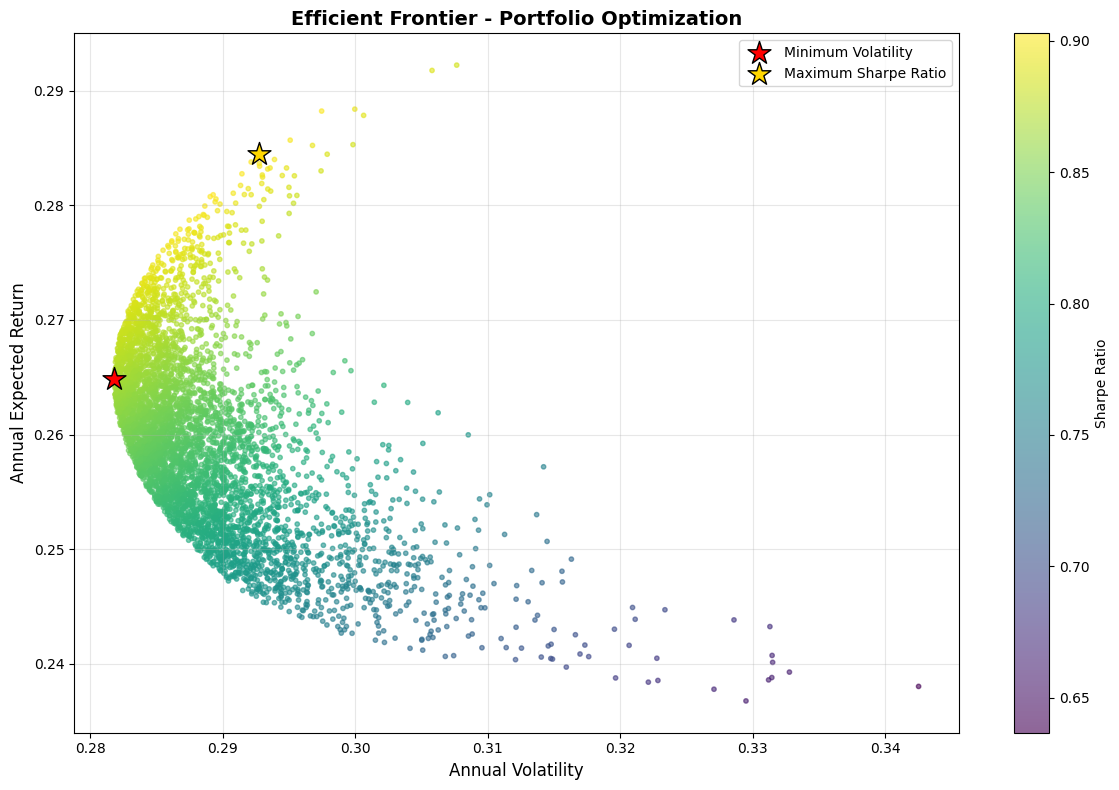


INDIVIDUAL STOCK PERFORMANCE
AAPL: Return=29.79%, Volatility=31.68%, Sharpe=0.877
AMZN: Return=23.27%, Volatility=35.96%, Sharpe=0.591
GOOGL: Return=25.76%, Volatility=32.50%, Sharpe=0.731
MSFT: Return=24.89%, Volatility=30.50%, Sharpe=0.751


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load data with robust error handling
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

def get_stock_data(tickers, start_date='2020-01-01', end_date='2025-01-01'):
    """
    Robust function to download stock data and extract adjusted close prices
    """
    try:
        # Download data
        data = yf.download(tickers, start=start_date, end=end_date, progress=False)
        
        if data.empty:
            raise ValueError("No data downloaded")
        
        print("Raw data shape:", data.shape)
        print("Column structure:", type(data.columns))
        
        # Handle different data structures
        if isinstance(data.columns, pd.MultiIndex):
            print("MultiIndex columns detected")
            print("Level 0 columns:", data.columns.get_level_values(0).unique().tolist())
            print("Level 1 columns:", data.columns.get_level_values(1).unique().tolist())
            
            # Try to get Adj Close, fallback to Close
            if 'Adj Close' in data.columns.get_level_values(0):
                price_data = data['Adj Close']
                print("Using 'Adj Close' prices")
            elif 'Close' in data.columns.get_level_values(0):
                price_data = data['Close']
                print("Using 'Close' prices (Adj Close not available)")
            else:
                # Use the first available price column
                available_cols = data.columns.get_level_values(0).unique().tolist()
                price_col = available_cols[0]
                price_data = data[price_col]
                print(f"Using '{price_col}' prices")
        else:
            # Single level columns
            print("Single level columns detected")
            print("Available columns:", data.columns.tolist())
            
            if len(tickers) == 1:
                # Single ticker case
                price_data = data
            else:
                # This shouldn't happen with multiple tickers, but handle it
                price_data = data
        
        # Ensure we have a DataFrame with proper column names
        if isinstance(price_data, pd.Series):
            price_data = price_data.to_frame(name=tickers[0])
        
        # Clean column names if needed
        price_data.columns = [col.replace(' ', '_') if isinstance(col, str) else col for col in price_data.columns]
        
        print(f"Final price data shape: {price_data.shape}")
        print(f"Final columns: {price_data.columns.tolist()}")
        
        return price_data
        
    except Exception as e:
        print(f"Error downloading data: {e}")
        # Fallback: download individual stocks
        print("Trying individual downloads...")
        price_data = pd.DataFrame()
        
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
                if 'Adj Close' in stock.columns:
                    price_data[ticker] = stock['Adj Close']
                else:
                    price_data[ticker] = stock['Close']
                print(f"Successfully downloaded {ticker}")
            except Exception as e2:
                print(f"Failed to download {ticker}: {e2}")
        
        return price_data

# Download the data
data = get_stock_data(tickers)

if data.empty:
    raise ValueError("Could not download any stock data")

# Calculate returns
returns = data.pct_change().dropna()
print(f"\nReturns data shape: {returns.shape}")
print("Sample of returns data:")
print(returns.head())

# Step 2: Calculate mean returns and covariance
mean_returns = returns.mean()
cov_matrix = returns.cov()

print(f"\nMean returns (daily):")
for i, ticker in enumerate(returns.columns):
    print(f"{ticker}: {mean_returns.iloc[i]:.4f}")

# Step 3: Define portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and volatility
    """
    ret = np.dot(weights, mean_returns) * 252  # annualized
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # annualized
    return ret, vol

# Step 4: Define objective (minimize volatility)
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Step 5: Optimization setup
num_assets = len(returns.columns)
init_guess = num_assets * [1. / num_assets]
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Optimize for minimum volatility
print("\nOptimizing for minimum volatility...")
opt = minimize(minimize_volatility, init_guess,
               args=(mean_returns, cov_matrix),
               method='SLSQP', bounds=bounds, constraints=constraints)

# Step 6: Results
if opt.success:
    opt_weights = opt.x
    ret, vol = portfolio_performance(opt_weights, mean_returns, cov_matrix)
    
    print("\n" + "="*50)
    print("MINIMUM VOLATILITY PORTFOLIO")
    print("="*50)
    for i, ticker in enumerate(returns.columns):
        print(f"{ticker}: {opt_weights[i]:.2%}")
    print(f"\nExpected Annual Return: {ret:.2%}")
    print(f"Expected Annual Volatility: {vol:.2%}")
    print(f"Sharpe Ratio (assuming 2% risk-free rate): {(ret - 0.02) / vol:.3f}")
else:
    print("Optimization failed:", opt.message)

# Additional analysis: Maximum Sharpe ratio portfolio
def maximize_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - risk_free_rate) / vol  # Negative because we're minimizing

print("\nOptimizing for maximum Sharpe ratio...")
opt_sharpe = minimize(maximize_sharpe, init_guess,
                     args=(mean_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)

if opt_sharpe.success:
    opt_weights_sharpe = opt_sharpe.x
    ret_sharpe, vol_sharpe = portfolio_performance(opt_weights_sharpe, mean_returns, cov_matrix)
    
    print("\n" + "="*50)
    print("MAXIMUM SHARPE RATIO PORTFOLIO")
    print("="*50)
    for i, ticker in enumerate(returns.columns):
        print(f"{ticker}: {opt_weights_sharpe[i]:.2%}")
    print(f"\nExpected Annual Return: {ret_sharpe:.2%}")
    print(f"Expected Annual Volatility: {vol_sharpe:.2%}")
    print(f"Sharpe Ratio: {(ret_sharpe - 0.02) / vol_sharpe:.3f}")

# Visualization: Efficient Frontier
def generate_random_portfolios(mean_returns, cov_matrix, num_portfolios=5000):
    """
    Generate random portfolios for efficient frontier visualization
    """
    results = np.zeros((3, num_portfolios))
    
    for i in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)  # Normalize to sum to 1
        
        # Calculate portfolio performance
        portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = (portfolio_return - 0.02) / portfolio_volatility  # Sharpe ratio
    
    return results

print("\nGenerating efficient frontier...")
results = generate_random_portfolios(mean_returns, cov_matrix)

# Create the plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], 
                     cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Sharpe Ratio')

# Add optimal portfolios
if opt.success:
    plt.scatter(vol, ret, marker='*', color='red', s=300, 
               label='Minimum Volatility', edgecolors='black', linewidth=1)

if opt_sharpe.success:
    plt.scatter(vol_sharpe, ret_sharpe, marker='*', color='gold', s=300, 
               label='Maximum Sharpe Ratio', edgecolors='black', linewidth=1)

plt.xlabel('Annual Volatility', fontsize=12)
plt.ylabel('Annual Expected Return', fontsize=12)
plt.title('Efficient Frontier - Portfolio Optimization', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Individual stock performance for comparison
print("\n" + "="*50)
print("INDIVIDUAL STOCK PERFORMANCE")
print("="*50)
for i, ticker in enumerate(returns.columns):
    annual_return = mean_returns.iloc[i] * 252
    annual_vol = returns.iloc[:, i].std() * np.sqrt(252)
    sharpe = (annual_return - 0.02) / annual_vol
    print(f"{ticker}: Return={annual_return:.2%}, Volatility={annual_vol:.2%}, Sharpe={sharpe:.3f}")

Testing with a simple example...
Attempting to download: ['AAPL', 'MSFT', 'GOOGL', '^GSPC']
Raw data shape: (501, 20)
Raw data columns: [('Close', 'AAPL'), ('Close', 'GOOGL'), ('Close', 'MSFT'), ('Close', '^GSPC'), ('High', 'AAPL'), ('High', 'GOOGL'), ('High', 'MSFT'), ('High', '^GSPC'), ('Low', 'AAPL'), ('Low', 'GOOGL'), ('Low', 'MSFT'), ('Low', '^GSPC'), ('Open', 'AAPL'), ('Open', 'GOOGL'), ('Open', 'MSFT'), ('Open', '^GSPC'), ('Volume', 'AAPL'), ('Volume', 'GOOGL'), ('Volume', 'MSFT'), ('Volume', '^GSPC')]
MultiIndex detected
Using Close (Adj Close not available)
Processed data shape: (501, 4)
Processed data columns: ['AAPL', 'GOOGL', 'MSFT', '^GSPC']
Data loaded successfully: 500 observations
Analysis period: 2022-01-01 to 2024-01-01
Data successfully loaded!
Available data shape: (501, 4)
Tickers being analyzed: ['AAPL', 'MSFT', 'GOOGL']

TESTING INDIVIDUAL COMPONENTS

1. Basic Statistics:
Mean returns: Ticker
AAPL     0.076163
MSFT     0.114820
GOOGL    0.042016
dtype: float64
St

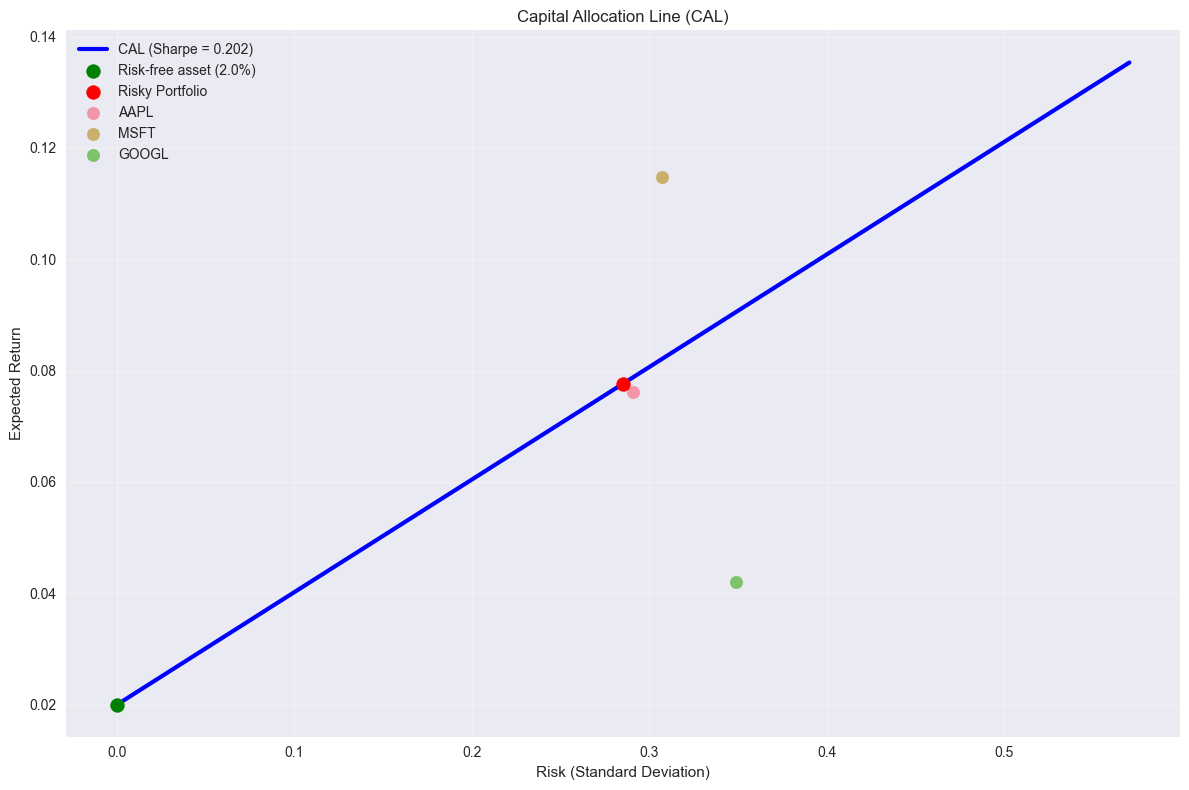


3. Testing CML...


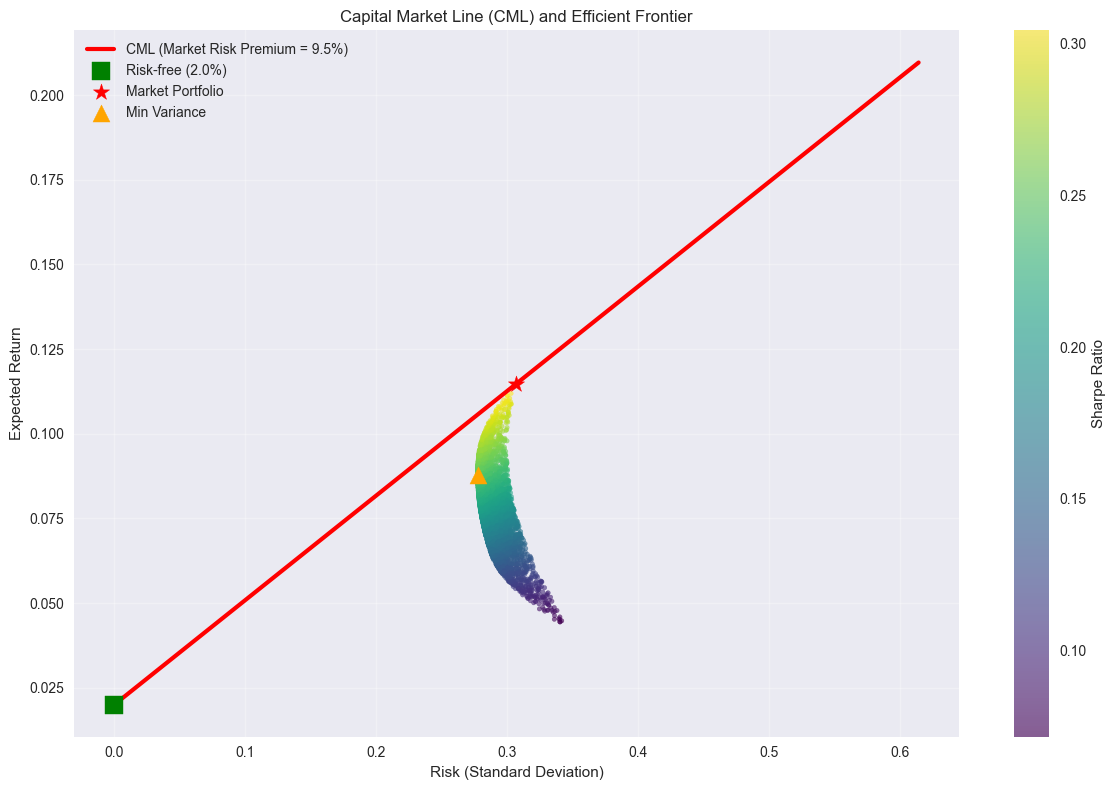


Market Portfolio (Max Sharpe Ratio) Weights:
AAPL: 0.00%
MSFT: 100.00%
GOOGL: 0.00%
Expected Return: 11.48%
Expected Risk: 30.73%
Sharpe Ratio: 0.309

4. Testing Beta/Alpha calculation...
Betas: {'AAPL': np.float64(1.264238833022131), 'MSFT': np.float64(1.2630323932626293), 'GOOGL': np.float64(1.3562860380677624)}
Alphas: {'AAPL': np.float64(0.05574444404756743), 'MSFT': np.float64(0.09442056607257783), 'GOOGL': np.float64(0.0201108296989527)}

5. Testing SML...


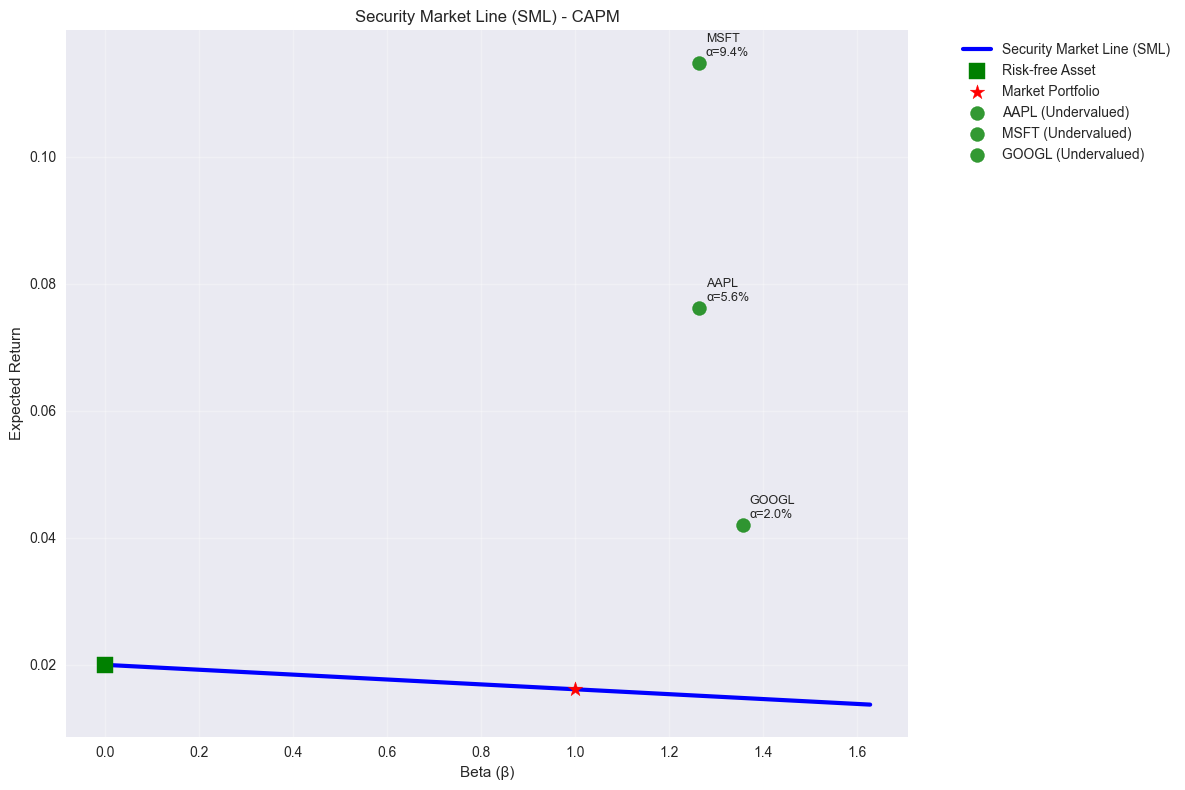


CAPM Analysis Results:
Stock  Beta   Alpha    CAPM Return  Actual Return Status
------------------------------------------------------------
AAPL   1.26   5.6%     1.5%         7.6%          Undervalued
MSFT   1.26   9.4%     1.5%         11.5%         Undervalued
GOOGL  1.36   2.0%     1.5%         4.2%          Undervalued

6. Testing SCL...


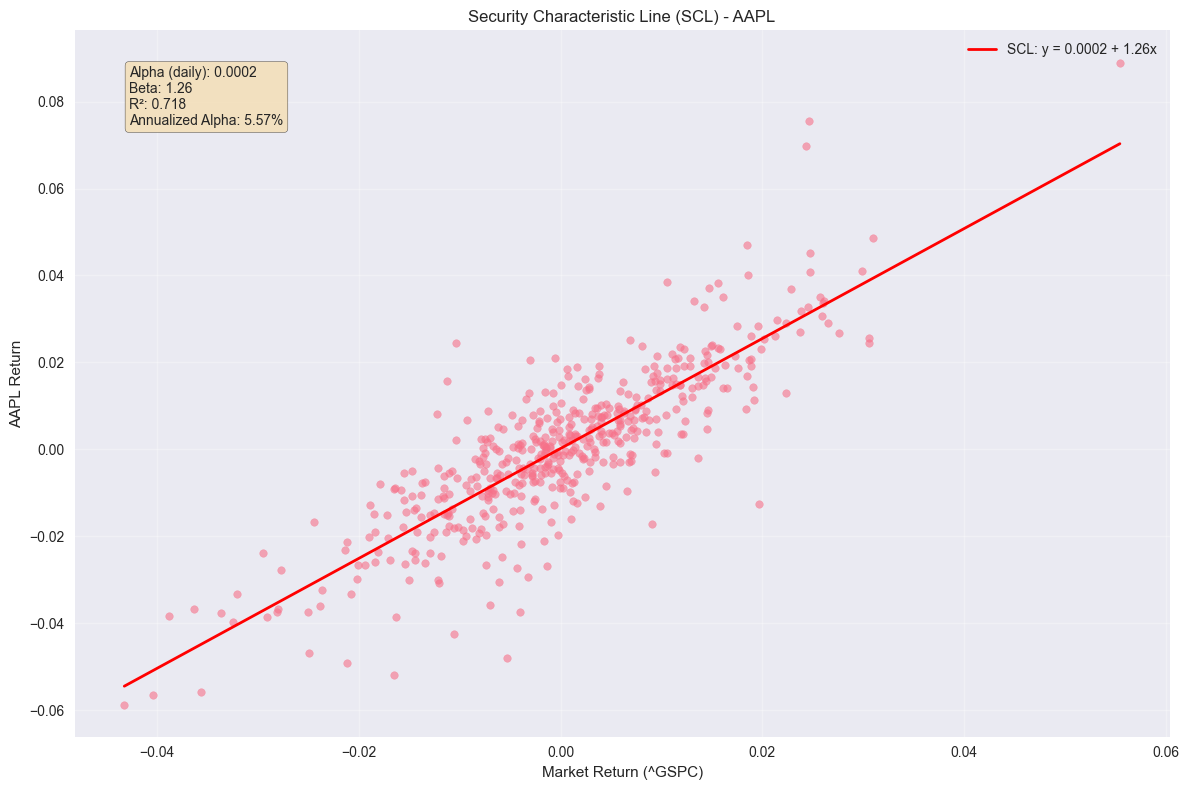

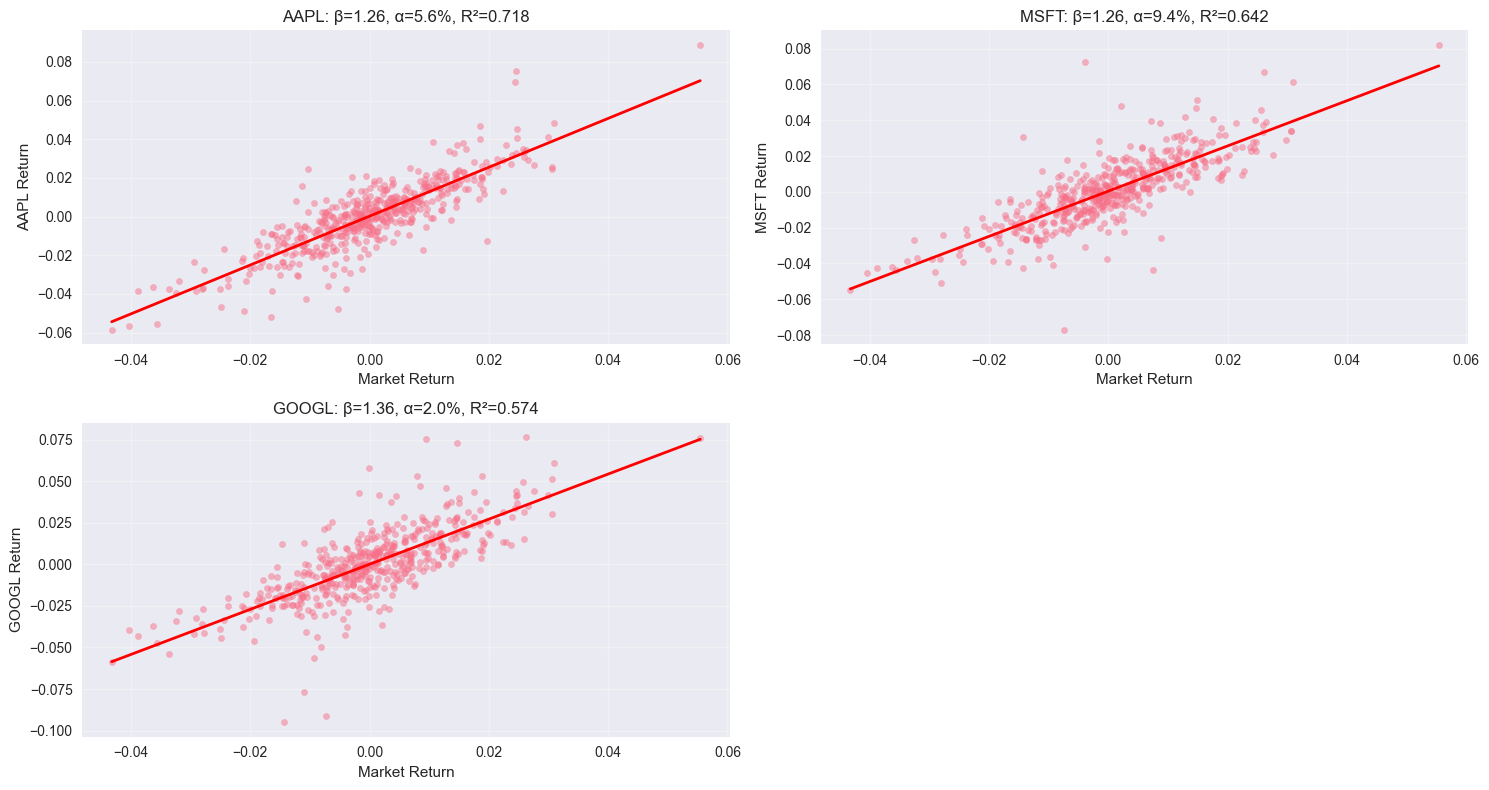


All individual tests passed! Running comprehensive analysis...
COMPREHENSIVE RISK-RETURN ANALYSIS

1. Data Summary:
   Stocks analyzed: AAPL, MSFT, GOOGL
   Market benchmark: ^GSPC
   Risk-free rate: 2.0%
   Analysis period: 500 daily observations

2. Individual Stock Statistics:
   Stock  Return   Risk     Sharpe  
   ------------------------------
   AAPL   7.6%     29.1%    0.193   
   MSFT   11.5%    30.7%    0.309   
   GOOGL  4.2%     34.9%    0.063   

3. Market Statistics:
   Market Return: 1.6%
   Market Risk: 19.5%
   Market Sharpe: -0.020

4. Running CAL Analysis...


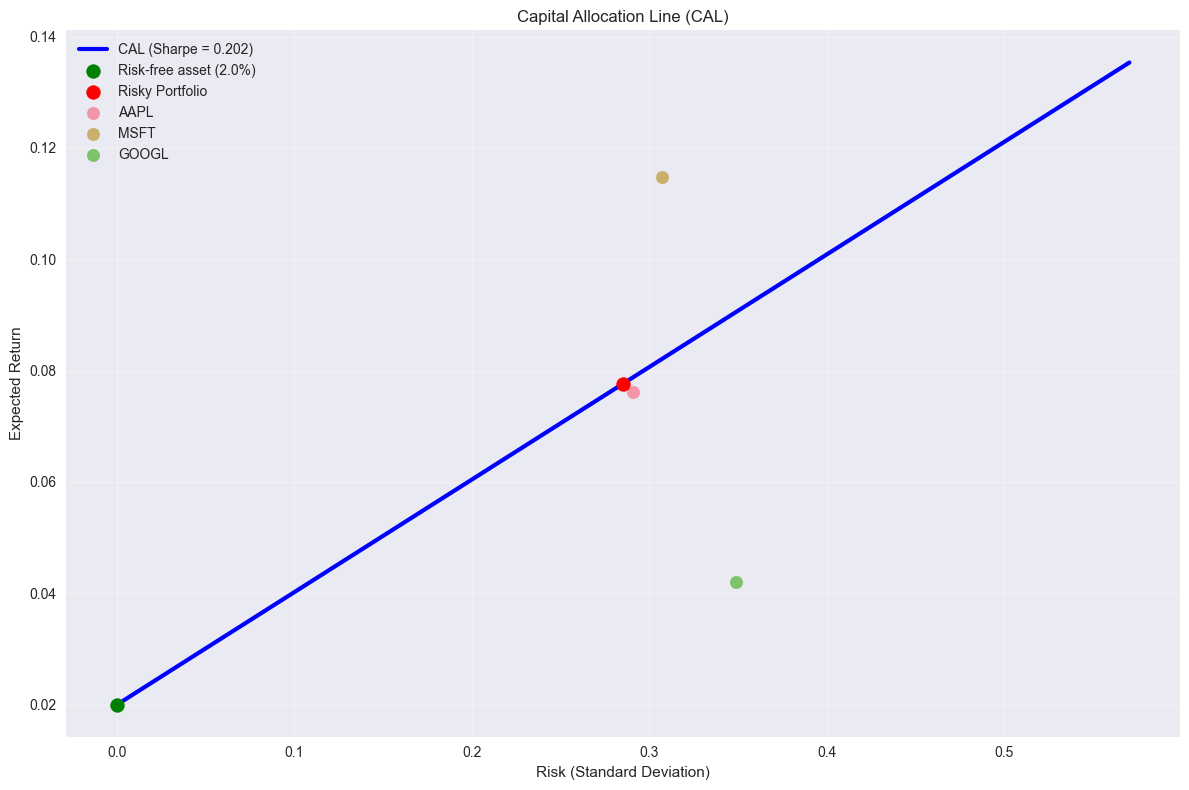


5. Running CML Analysis...


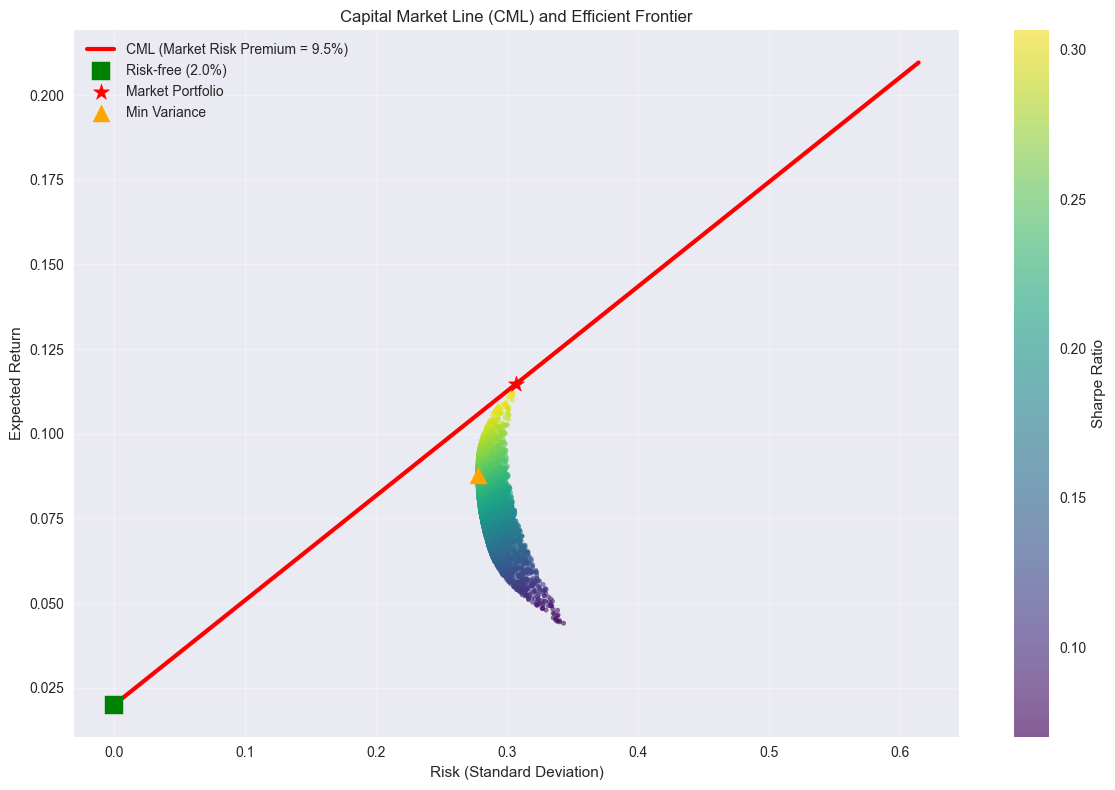


Market Portfolio (Max Sharpe Ratio) Weights:
AAPL: 0.00%
MSFT: 100.00%
GOOGL: 0.00%
Expected Return: 11.48%
Expected Risk: 30.73%
Sharpe Ratio: 0.309

6. Running SML Analysis...


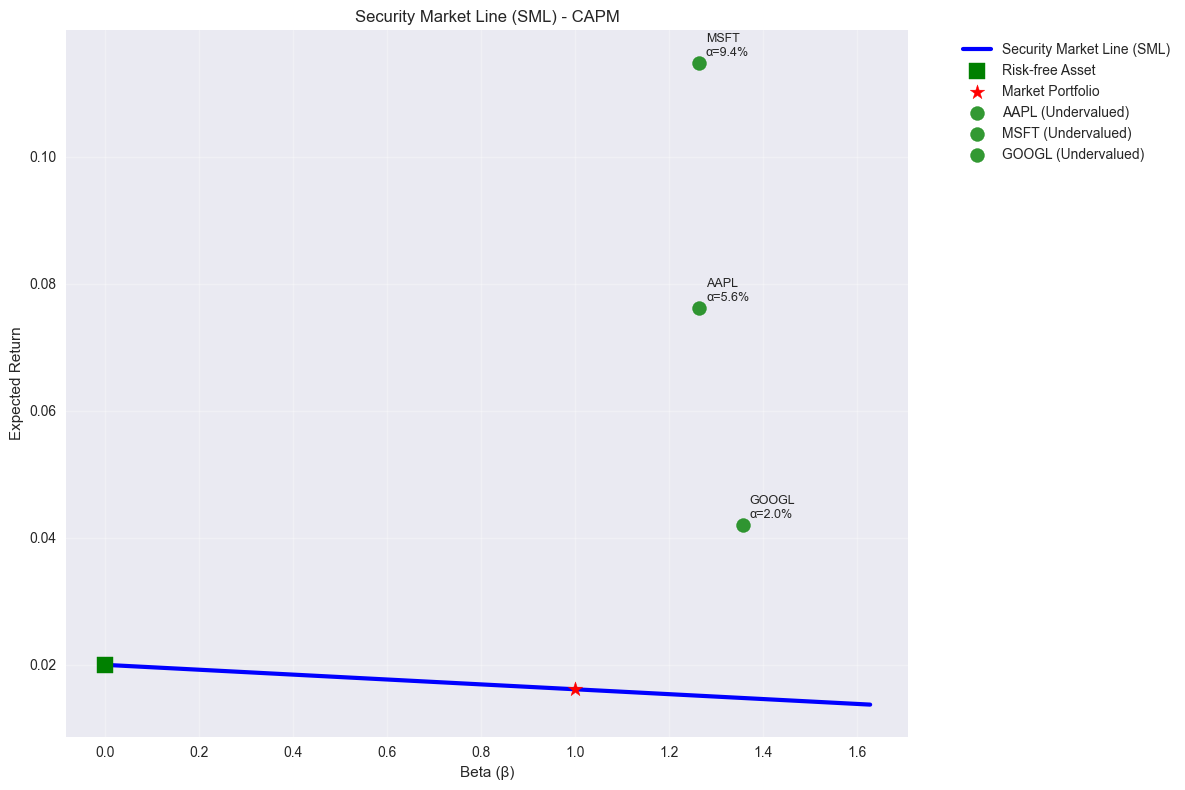


CAPM Analysis Results:
Stock  Beta   Alpha    CAPM Return  Actual Return Status
------------------------------------------------------------
AAPL   1.26   5.6%     1.5%         7.6%          Undervalued
MSFT   1.26   9.4%     1.5%         11.5%         Undervalued
GOOGL  1.36   2.0%     1.5%         4.2%          Undervalued

7. Running SCL Analysis...


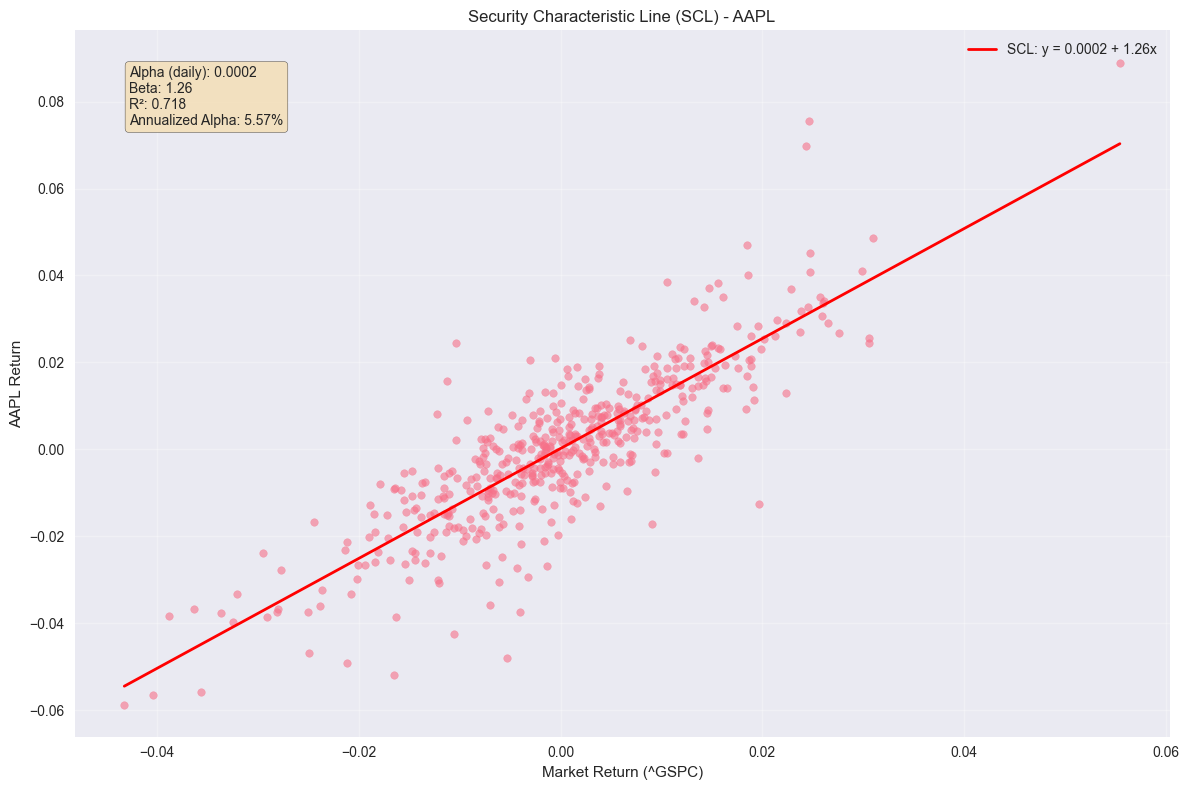

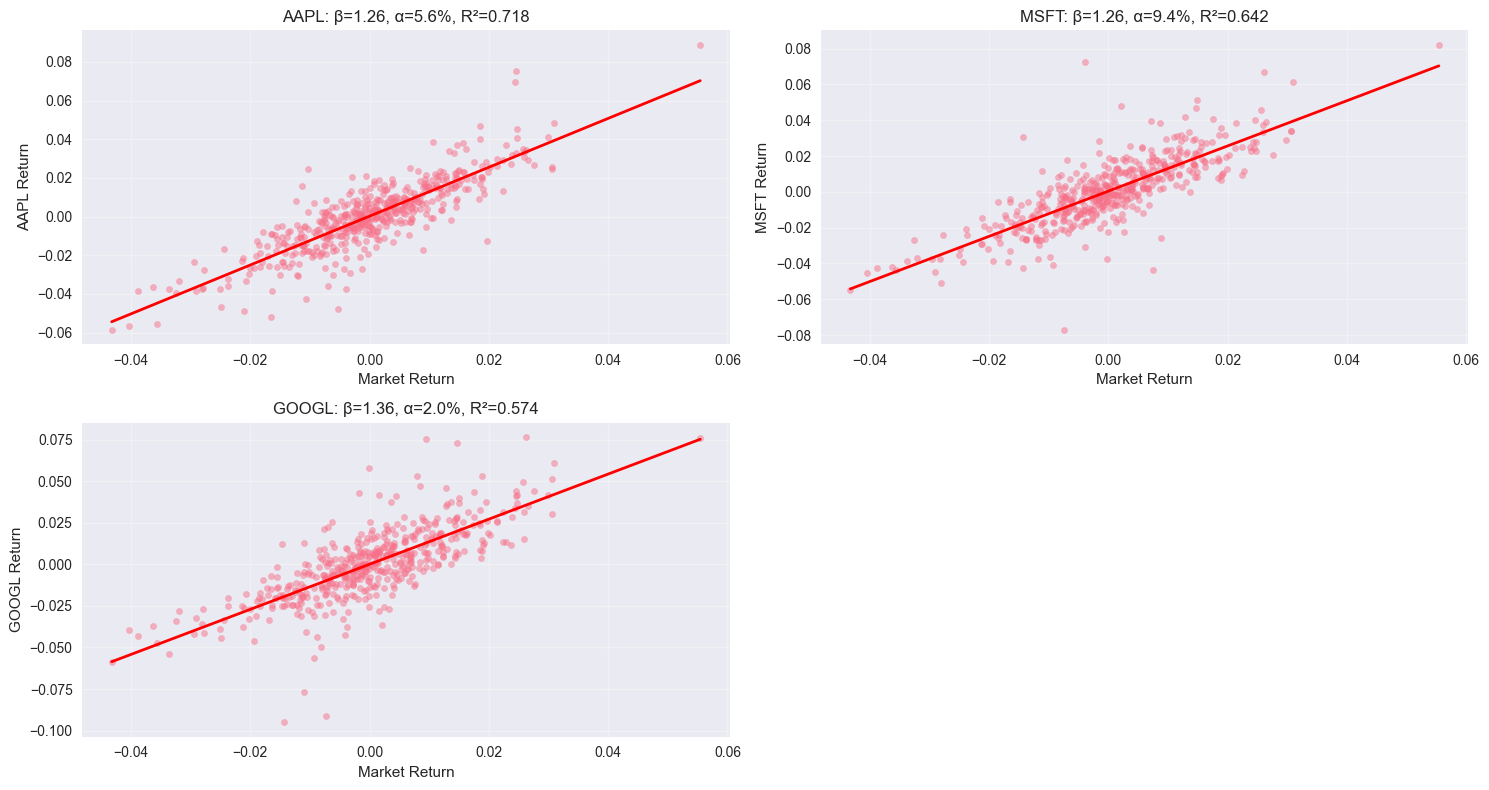


Analysis complete!

Success! All analyses completed.

Script execution completed.


In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class RiskReturnAnalyzer:
    def __init__(self, tickers, market_ticker='^GSPC', start_date='2020-01-01', end_date='2024-01-01', risk_free_rate=0.02):
        """
        Initialize the analyzer with stock data
        
        Parameters:
        tickers: list of stock symbols
        market_ticker: market index symbol (default: S&P 500)
        start_date, end_date: date range for data
        risk_free_rate: annual risk-free rate
        """
        self.tickers = tickers
        self.market_ticker = market_ticker
        self.risk_free_rate = risk_free_rate
        
        # Download data
        print("Downloading stock data...")
        self.stock_data = self._download_data(tickers + [market_ticker], start_date, end_date)
        
        # Verify we have all required data
        if market_ticker not in self.stock_data.columns:
            raise ValueError(f"Market ticker {market_ticker} not found in downloaded data. Available columns: {self.stock_data.columns.tolist()}")
        
        missing_tickers = [t for t in tickers if t not in self.stock_data.columns]
        if missing_tickers:
            print(f"Warning: Missing tickers: {missing_tickers}")
            # Update tickers list to only include available ones
            self.tickers = [t for t in tickers if t in self.stock_data.columns]
            print(f"Analysis will proceed with: {self.tickers}")
        
        # Calculate returns
        self.returns = self.stock_data.pct_change().dropna()
        self.market_returns = self.returns[market_ticker]
        self.stock_returns = self.returns[self.tickers]
        
        # Calculate statistics
        self.mean_returns = self.stock_returns.mean() * 252  # Annualized
        self.std_returns = self.stock_returns.std() * np.sqrt(252)  # Annualized
        self.market_mean = self.market_returns.mean() * 252
        self.market_std = self.market_returns.std() * np.sqrt(252)
        
        # Calculate covariance matrix
        self.cov_matrix = self.stock_returns.cov() * 252  # Annualized
        
        print(f"Data loaded successfully: {len(self.returns)} observations")
        print(f"Analysis period: {start_date} to {end_date}")
    
    def _download_data(self, symbols, start, end):
        """Download and clean stock data with robust error handling"""
        print(f"Attempting to download: {symbols}")
        
        # Method 1: Try bulk download
        try:
            data = yf.download(symbols, start=start, end=end, progress=False)
            print(f"Raw data shape: {data.shape}")
            print(f"Raw data columns: {data.columns.tolist() if hasattr(data.columns, 'tolist') else 'Unknown'}")
            
            if isinstance(data.columns, pd.MultiIndex):
                print("MultiIndex detected")
                if 'Adj Close' in data.columns.get_level_values(0):
                    data = data['Adj Close']
                    print("Using Adj Close")
                elif 'Close' in data.columns.get_level_values(0):
                    data = data['Close']
                    print("Using Close (Adj Close not available)")
                else:
                    # Use first available price column
                    price_cols = data.columns.get_level_values(0).unique()
                    data = data[price_cols[0]]
                    print(f"Using {price_cols[0]}")
            
            print(f"Processed data shape: {data.shape}")
            print(f"Processed data columns: {data.columns.tolist()}")
            
            # Check if all symbols are present
            missing_symbols = [s for s in symbols if s not in data.columns]
            if missing_symbols:
                print(f"Missing symbols after bulk download: {missing_symbols}")
                raise ValueError(f"Missing symbols: {missing_symbols}")
            
            return data.dropna()
            
        except Exception as e:
            print(f"Bulk download failed: {e}")
            
        # Method 2: Individual downloads
        print("Trying individual downloads...")
        price_data = pd.DataFrame()
        
        for symbol in symbols:
            try:
                print(f"Downloading {symbol}...")
                stock = yf.download(symbol, start=start, end=end, progress=False)
                
                if stock.empty:
                    print(f"No data for {symbol}")
                    continue
                
                # Handle different column structures
                if 'Adj Close' in stock.columns:
                    price_data[symbol] = stock['Adj Close']
                elif 'Close' in stock.columns:
                    price_data[symbol] = stock['Close']
                else:
                    # Use the first price column available
                    price_cols = [col for col in stock.columns if any(x in col.lower() for x in ['close', 'price'])]
                    if price_cols:
                        price_data[symbol] = stock[price_cols[0]]
                    else:
                        price_data[symbol] = stock.iloc[:, 0]  # Use first column
                
                print(f"Successfully downloaded {symbol}")
                
            except Exception as e2:
                print(f"Failed to download {symbol}: {e2}")
                
                # Try alternative symbols for market indices
                if symbol == '^GSPC':
                    alternatives = ['SPY', 'VOO', '^SPX']
                    for alt in alternatives:
                        try:
                            print(f"Trying alternative {alt} for {symbol}")
                            alt_stock = yf.download(alt, start=start, end=end, progress=False)
                            if not alt_stock.empty:
                                if 'Adj Close' in alt_stock.columns:
                                    price_data[symbol] = alt_stock['Adj Close']  # Keep original symbol name
                                else:
                                    price_data[symbol] = alt_stock['Close']
                                print(f"Successfully downloaded {alt} as replacement for {symbol}")
                                break
                        except:
                            continue
        
        if price_data.empty:
            raise ValueError("Could not download any data")
        
        print(f"Final data shape: {price_data.shape}")
        print(f"Final columns: {price_data.columns.tolist()}")
        
        return price_data.dropna()
    
    def calculate_portfolio_performance(self, weights):
        """Calculate portfolio return and risk"""
        portfolio_return = np.dot(weights, self.mean_returns)
        portfolio_variance = np.dot(weights.T, np.dot(self.cov_matrix, weights))
        portfolio_std = np.sqrt(portfolio_variance)
        return portfolio_return, portfolio_std
    
    def generate_efficient_frontier(self, num_portfolios=1000):
        """Generate efficient frontier using random portfolios"""
        num_assets = len(self.tickers)
        results = np.zeros((3, num_portfolios))
        weights_record = []
        
        for i in range(num_portfolios):
            # Generate random weights
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            weights_record.append(weights)
            
            # Calculate portfolio performance
            portfolio_return, portfolio_std = self.calculate_portfolio_performance(weights)
            
            results[0, i] = portfolio_return
            results[1, i] = portfolio_std
            results[2, i] = (portfolio_return - self.risk_free_rate) / portfolio_std  # Sharpe ratio
        
        return results, weights_record
    
    def find_optimal_portfolios(self):
        """Find minimum variance and maximum Sharpe ratio portfolios"""
        num_assets = len(self.tickers)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(num_assets))
        initial_guess = num_assets * [1. / num_assets]
        
        # Minimum variance portfolio
        def minimize_variance(weights):
            return self.calculate_portfolio_performance(weights)[1]
        
        min_var_result = minimize(minimize_variance, initial_guess, 
                                method='SLSQP', bounds=bounds, constraints=constraints)
        
        # Maximum Sharpe ratio portfolio
        def negative_sharpe(weights):
            ret, vol = self.calculate_portfolio_performance(weights)
            return -(ret - self.risk_free_rate) / vol
        
        max_sharpe_result = minimize(negative_sharpe, initial_guess,
                                   method='SLSQP', bounds=bounds, constraints=constraints)
        
        return min_var_result, max_sharpe_result
    
    def plot_cal(self, risky_portfolio_weights=None):
        """Plot Capital Allocation Line"""
        if risky_portfolio_weights is None:
            # Use equal weights as default
            risky_portfolio_weights = np.array([1/len(self.tickers)] * len(self.tickers))
        
        # Calculate risky portfolio performance
        risky_return, risky_std = self.calculate_portfolio_performance(risky_portfolio_weights)
        
        # Generate CAL
        risk_range = np.linspace(0, risky_std * 2, 100)
        cal_returns = self.risk_free_rate + (risky_return - self.risk_free_rate) * (risk_range / risky_std)
        
        plt.figure(figsize=(12, 8))
        plt.plot(risk_range, cal_returns, 'b-', linewidth=3, label=f'CAL (Sharpe = {(risky_return - self.risk_free_rate) / risky_std:.3f})')
        plt.scatter(0, self.risk_free_rate, color='green', s=100, label=f'Risk-free asset ({self.risk_free_rate:.1%})', zorder=5)
        plt.scatter(risky_std, risky_return, color='red', s=100, label='Risky Portfolio', zorder=5)
        
        # Add individual stocks
        for i, ticker in enumerate(self.tickers):
            plt.scatter(self.std_returns[ticker], self.mean_returns[ticker], 
                       alpha=0.7, s=80, label=ticker)
        
        plt.xlabel('Risk (Standard Deviation)')
        plt.ylabel('Expected Return')
        plt.title('Capital Allocation Line (CAL)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return risky_return, risky_std
    
    def plot_cml(self):
        """Plot Capital Market Line with Efficient Frontier"""
        # Generate efficient frontier
        frontier_results, weights_record = self.generate_efficient_frontier(5000)
        
        # Find optimal portfolios
        min_var_result, max_sharpe_result = self.find_optimal_portfolios()
        
        # Market portfolio (max Sharpe ratio portfolio)
        market_weights = max_sharpe_result.x
        market_return, market_std = self.calculate_portfolio_performance(market_weights)
        
        # Generate CML
        risk_range = np.linspace(0, market_std * 2, 100)
        cml_returns = self.risk_free_rate + (market_return - self.risk_free_rate) * (risk_range / market_std)
        
        plt.figure(figsize=(12, 8))
        
        # Plot efficient frontier
        plt.scatter(frontier_results[1, :], frontier_results[0, :], 
                   c=frontier_results[2, :], cmap='viridis', alpha=0.6, s=10)
        plt.colorbar(label='Sharpe Ratio')
        
        # Plot CML
        plt.plot(risk_range, cml_returns, 'r-', linewidth=3, 
                label=f'CML (Market Risk Premium = {market_return - self.risk_free_rate:.1%})')
        
        # Mark important points
        plt.scatter(0, self.risk_free_rate, color='green', s=150, 
                   label=f'Risk-free ({self.risk_free_rate:.1%})', zorder=5, marker='s')
        plt.scatter(market_std, market_return, color='red', s=150, 
                   label='Market Portfolio', zorder=5, marker='*')
        
        # Min variance portfolio
        min_var_return, min_var_std = self.calculate_portfolio_performance(min_var_result.x)
        plt.scatter(min_var_std, min_var_return, color='orange', s=150, 
                   label='Min Variance', zorder=5, marker='^')
        
        plt.xlabel('Risk (Standard Deviation)')
        plt.ylabel('Expected Return')
        plt.title('Capital Market Line (CML) and Efficient Frontier')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print portfolio composition
        print("\nMarket Portfolio (Max Sharpe Ratio) Weights:")
        for ticker, weight in zip(self.tickers, market_weights):
            print(f"{ticker}: {weight:.2%}")
        print(f"Expected Return: {market_return:.2%}")
        print(f"Expected Risk: {market_std:.2%}")
        print(f"Sharpe Ratio: {(market_return - self.risk_free_rate) / market_std:.3f}")
        
        return market_weights
    
    def calculate_beta_alpha(self):
        """Calculate beta and alpha for each stock using SCL"""
        betas = {}
        alphas = {}
        r_squares = {}
        
        for ticker in self.tickers:
            # Run regression: stock_return = alpha + beta * market_return + error
            stock_ret = self.returns[ticker].dropna()
            market_ret = self.returns[self.market_ticker].dropna()
            
            # Align data
            common_index = stock_ret.index.intersection(market_ret.index)
            stock_ret = stock_ret[common_index]
            market_ret = market_ret[common_index]
            
            # Linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(market_ret, stock_ret)
            
            betas[ticker] = slope
            alphas[ticker] = intercept * 252  # Annualized alpha
            r_squares[ticker] = r_value ** 2
        
        return betas, alphas, r_squares
    
    def plot_sml(self):
        """Plot Security Market Line"""
        betas, alphas, r_squares = self.calculate_beta_alpha()
        
        # Calculate expected returns using CAPM
        capm_returns = {}
        for ticker in self.tickers:
            capm_returns[ticker] = self.risk_free_rate + betas[ticker] * (self.market_mean - self.risk_free_rate)
        
        # Create SML
        beta_range = np.linspace(0, max(betas.values()) * 1.2, 100)
        sml_returns = self.risk_free_rate + beta_range * (self.market_mean - self.risk_free_rate)
        
        plt.figure(figsize=(12, 8))
        
        # Plot SML
        plt.plot(beta_range, sml_returns, 'b-', linewidth=3, label='Security Market Line (SML)')
        
        # Plot risk-free asset and market
        plt.scatter(0, self.risk_free_rate, color='green', s=120, label='Risk-free Asset', zorder=5, marker='s')
        plt.scatter(1, self.market_mean, color='red', s=120, label='Market Portfolio', zorder=5, marker='*')
        
        # Plot individual securities
        for ticker in self.tickers:
            actual_return = self.mean_returns[ticker]
            expected_return = capm_returns[ticker]
            beta = betas[ticker]
            
            color = 'green' if actual_return > expected_return else 'red'
            status = 'Undervalued' if actual_return > expected_return else 'Overvalued'
            
            plt.scatter(beta, actual_return, s=100, alpha=0.8, 
                       label=f'{ticker} ({status})', color=color)
            
            # Add annotations
            plt.annotate(f'{ticker}\nα={alphas[ticker]:.1%}', 
                        (beta, actual_return), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel('Beta (β)')
        plt.ylabel('Expected Return')
        plt.title('Security Market Line (SML) - CAPM')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print results
        print("\nCAPM Analysis Results:")
        print("="*60)
        print(f"{'Stock':<6} {'Beta':<6} {'Alpha':<8} {'CAPM Return':<12} {'Actual Return':<13} {'Status'}")
        print("-"*60)
        for ticker in self.tickers:
            actual = self.mean_returns[ticker]
            expected = capm_returns[ticker]
            status = 'Undervalued' if actual > expected else 'Overvalued  '
            print(f"{ticker:<6} {betas[ticker]:<6.2f} {alphas[ticker]:<8.1%} {expected:<12.1%} {actual:<13.1%} {status}")
        
        return betas, alphas, capm_returns
    
    def plot_scl(self, ticker=None):
        """Plot Security Characteristic Lines"""
        if ticker is None:
            ticker = self.tickers[0]  # Use first ticker as default
        
        betas, alphas, r_squares = self.calculate_beta_alpha()
        
        # Get data for the specific stock
        stock_ret = self.returns[ticker].dropna()
        market_ret = self.returns[self.market_ticker].dropna()
        
        # Align data
        common_index = stock_ret.index.intersection(market_ret.index)
        stock_ret = stock_ret[common_index]
        market_ret = market_ret[common_index]
        
        # Create scatter plot with regression line
        plt.figure(figsize=(12, 8))
        
        # Scatter plot
        plt.scatter(market_ret, stock_ret, alpha=0.6, s=30)
        
        # Regression line
        slope = betas[ticker]
        intercept = alphas[ticker] / 252  # Daily alpha
        x_range = np.linspace(market_ret.min(), market_ret.max(), 100)
        y_range = intercept + slope * x_range
        
        plt.plot(x_range, y_range, 'r-', linewidth=2, 
                label=f'SCL: y = {intercept:.4f} + {slope:.2f}x')
        
        plt.xlabel(f'Market Return ({self.market_ticker})')
        plt.ylabel(f'{ticker} Return')
        plt.title(f'Security Characteristic Line (SCL) - {ticker}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = f'Alpha (daily): {intercept:.4f}\n'
        stats_text += f'Beta: {slope:.2f}\n'
        stats_text += f'R²: {r_squares[ticker]:.3f}\n'
        stats_text += f'Annualized Alpha: {alphas[ticker]:.2%}'
        
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                verticalalignment='top', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Create SCL for all stocks
        self.plot_all_scl()
        
        return slope, intercept, r_squares[ticker]
    
    def plot_all_scl(self):
        """Plot SCL for all stocks in subplots"""
        n_stocks = len(self.tickers)
        cols = 2
        rows = (n_stocks + 1) // 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
        if n_stocks == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        
        betas, alphas, r_squares = self.calculate_beta_alpha()
        
        for i, ticker in enumerate(self.tickers):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Get data
            stock_ret = self.returns[ticker].dropna()
            market_ret = self.returns[self.market_ticker].dropna()
            common_index = stock_ret.index.intersection(market_ret.index)
            stock_ret = stock_ret[common_index]
            market_ret = market_ret[common_index]
            
            # Plot
            ax.scatter(market_ret, stock_ret, alpha=0.5, s=20)
            
            # Regression line
            slope = betas[ticker]
            intercept = alphas[ticker] / 252
            x_range = np.linspace(market_ret.min(), market_ret.max(), 100)
            y_range = intercept + slope * x_range
            ax.plot(x_range, y_range, 'r-', linewidth=2)
            
            ax.set_xlabel('Market Return')
            ax.set_ylabel(f'{ticker} Return')
            ax.set_title(f'{ticker}: β={slope:.2f}, α={alphas[ticker]:.1%}, R²={r_squares[ticker]:.3f}')
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_stocks, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def comprehensive_analysis(self):
        """Run complete analysis with all four concepts"""
        print("="*80)
        print("COMPREHENSIVE RISK-RETURN ANALYSIS")
        print("="*80)
        
        print(f"\n1. Data Summary:")
        print(f"   Stocks analyzed: {', '.join(self.tickers)}")
        print(f"   Market benchmark: {self.market_ticker}")
        print(f"   Risk-free rate: {self.risk_free_rate:.1%}")
        print(f"   Analysis period: {len(self.returns)} daily observations")
        
        print(f"\n2. Individual Stock Statistics:")
        print(f"   {'Stock':<6} {'Return':<8} {'Risk':<8} {'Sharpe':<8}")
        print(f"   {'-'*30}")
        for ticker in self.tickers:
            sharpe = (self.mean_returns[ticker] - self.risk_free_rate) / self.std_returns[ticker]
            print(f"   {ticker:<6} {self.mean_returns[ticker]:<8.1%} {self.std_returns[ticker]:<8.1%} {sharpe:<8.3f}")
        
        print(f"\n3. Market Statistics:")
        market_sharpe = (self.market_mean - self.risk_free_rate) / self.market_std
        print(f"   Market Return: {self.market_mean:.1%}")
        print(f"   Market Risk: {self.market_std:.1%}")
        print(f"   Market Sharpe: {market_sharpe:.3f}")
        
        # Run all analyses
        print(f"\n4. Running CAL Analysis...")
        self.plot_cal()
        
        print(f"\n5. Running CML Analysis...")
        market_weights = self.plot_cml()
        
        print(f"\n6. Running SML Analysis...")
        betas, alphas, capm_returns = self.plot_sml()
        
        print(f"\n7. Running SCL Analysis...")
        self.plot_scl()
        
        print(f"\nAnalysis complete!")
        
        return {
            'market_weights': market_weights,
            'betas': betas,
            'alphas': alphas,
            'capm_returns': capm_returns
        }

# Example usage with better error handling
if __name__ == "__main__":
    # Test with a simple example first
    print("Testing with a simple example...")
    
    try:
        # Define stocks to analyze (start with fewer stocks for testing)
        stocks = ['AAPL', 'MSFT', 'GOOGL']
        
        # Create analyzer instance
        analyzer = RiskReturnAnalyzer(
            tickers=stocks,
            market_ticker='^GSPC',  # S&P 500
            start_date='2022-01-01',  # Shorter period for testing
            end_date='2024-01-01',
            risk_free_rate=0.02  # 2% annual risk-free rate
        )
        
        print("Data successfully loaded!")
        print(f"Available data shape: {analyzer.stock_data.shape}")
        print(f"Tickers being analyzed: {analyzer.tickers}")
        
        # Test individual components first
        print("\n" + "="*50)
        print("TESTING INDIVIDUAL COMPONENTS")
        print("="*50)
        
        # Test 1: Basic statistics
        print("\n1. Basic Statistics:")
        print(f"Mean returns: {analyzer.mean_returns}")
        print(f"Standard deviations: {analyzer.std_returns}")
        
        # Test 2: CAL
        print("\n2. Testing CAL...")
        analyzer.plot_cal()
        
        # Test 3: CML
        print("\n3. Testing CML...")
        market_weights = analyzer.plot_cml()
        
        # Test 4: Beta/Alpha calculation
        print("\n4. Testing Beta/Alpha calculation...")
        betas, alphas, r_squares = analyzer.calculate_beta_alpha()
        print(f"Betas: {betas}")
        print(f"Alphas: {alphas}")
        
        # Test 5: SML
        print("\n5. Testing SML...")
        betas, alphas, capm_returns = analyzer.plot_sml()
        
        # Test 6: SCL
        print("\n6. Testing SCL...")
        analyzer.plot_scl(analyzer.tickers[0])
        
        print("\nAll individual tests passed! Running comprehensive analysis...")
        
        # Run comprehensive analysis
        results = analyzer.comprehensive_analysis()
        
        print("\nSuccess! All analyses completed.")
        
    except Exception as e:
        print(f"Error occurred: {e}")
        print("Let's try with alternative market ticker...")
        
        try:
            # Try with SPY instead of ^GSPC
            analyzer_alt = RiskReturnAnalyzer(
                tickers=['AAPL', 'MSFT'],  # Even fewer stocks
                market_ticker='SPY',  # Use SPY ETF instead
                start_date='2022-01-01',
                end_date='2024-01-01',
                risk_free_rate=0.02
            )
            
            print("Alternative setup successful!")
            results = analyzer_alt.comprehensive_analysis()
            
        except Exception as e2:
            print(f"Alternative also failed: {e2}")
            print("Please check your internet connection and try again.")
            
            # Show debug information
            print("\nDebug information:")
            import yfinance as yf
            test_data = yf.download('AAPL', start='2023-01-01', end='2023-02-01', progress=False)
            print(f"Test download shape: {test_data.shape}")
            print(f"Test download columns: {test_data.columns.tolist()}")
    
    print("\nScript execution completed.")